#Basic Imports

In [22]:
# Essential Libraries
import numpy as np
import pandas as pd
from collections import Counter

# Scikit-Learn: Datasets
from sklearn.datasets import load_iris, load_breast_cancer

# Scikit-Learn: Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder

# Scikit-Learn: Model Selection
from sklearn.model_selection import train_test_split

# Scikit-Learn: Support Vector Machine
from sklearn.svm import SVC

# Scikit-Learn: Dimensionality Reduction
from sklearn.decomposition import PCA

# Scikit-Learn: Metrics
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

# Qiskit: Installation
# !pip install -q qiskit qiskit-machine-learning

# Qiskit: Basic Functionality
from qiskit import Aer, execute, BasicAer

# Qiskit: Circuit
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

# Qiskit: Circuit Library
from qiskit.circuit.library import (PauliFeatureMap, ZFeatureMap, ZZFeatureMap,
                                    TwoLocal, NLocal, RealAmplitudes, EfficientSU2,
                                    HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate)

# Qiskit: Machine Learning
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
from qiskit_machine_learning.algorithms import VQC
from qiskit.utils import QuantumInstance, algorithm_globals

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Functions to Load the Datasets

In [4]:
# For working in google_colab
from google.colab import drive
drive.mount('/content/drive')

# Add the folder to your google drive account to run it and change the directory path.
# LINK of Datasets: https://drive.google.com/drive/folders/12K1jIqNfU_yVOSdn_pqOX9kIVAgLRFPg?usp=sharing

import os
# Save all datasets
directory_path = "/content/drive/MyDrive/KPCA_PCA/datasets/"
dataset_ex = ['.csv', '.data', '.mat', '.xls' ]
datasets = [f for f in os.listdir(directory_path)]# if ( f.endswith('.data') or f.endswith('.csv') or f.endswith('.mat') or f.endswith('.xls')) and f not in dataset_ex]
datasets

#read dataset and set the name of the columns
def vowelData ():
    name = 'vowel'

    vowel = arff.loadarff(directory_path+"vowels")

    vowel_data = pd.DataFrame(vowel[0])
    vowel_data.columns = ['feature{}'.format(i) for i in range(0,vowel_data.shape[1])]

    vowel_data = vowel_data.drop_duplicates()
    vowel_data.reset_index(drop=True,inplace=True)

    mappings = {}
    count = 0
    for i in list(Counter(vowel_data['feature12']).keys()):
        mappings[i] = count
        count = count +1

    mappings_users = {}
    count_users = 0
    for i in list(Counter(vowel_data['feature0']).keys()):
        mappings_users[i] = count_users
        count_users = count_users +1

    vowel_data.feature12 = vowel_data.feature12.fillna('nan').apply(lambda x: mappings[x])
    vowel_data.feature0 = vowel_data.feature0.fillna('nan').apply(lambda x: mappings_users[x])
    vowel_data.feature1 = vowel_data.feature1.fillna('nan').apply(lambda x: {b'Male':0,b'Female':1}[x])

    return vowel_data, vowel_data.drop(columns='feature12'),vowel_data.feature12

Mounted at /content/drive


In [5]:
def irisData ():
    name = 'iris'
    iris = load_iris()


    iris_dataset = pd.DataFrame(data=iris, columns=iris.feature_names)

    iris_dataset = iris_dataset.drop_duplicates()
    iris_dataset.reset_index(drop=True,inplace=True)

    iris_dataset.columns = ['feature{}'.format(i) for i in range(0,iris_dataset.shape[1])]

    dataset = pd.DataFrame(iris.data).assign(target=iris.target)

    return dataset, iris.data, iris.target

In [6]:
def breastcancerData():
    name = 'breast_cancer'
    breast_cancer = load_breast_cancer()
    breast_cancerData = pd.DataFrame(data=breast_cancer, columns=breast_cancer.feature_names)

    breast_cancerData = breast_cancerData.drop_duplicates()
    breast_cancerData.reset_index(drop=True,inplace=True)

    breast_cancerData.columns = ['feature{}'.format(i) for i in range(0,breast_cancerData.shape[1])]

    dataset = pd.DataFrame(breast_cancer.data).assign(target=breast_cancer.target)

    return dataset, breast_cancer.data, breast_cancer.target

In [7]:
from qiskit_machine_learning.datasets import ad_hoc_data

def adhoc():
  n_features = 2
  x, y, test_features, test_labels, adhoc_total = ad_hoc_data(
      training_size=500,
      test_size=5,
      n=n_features,
      gap=0.3,
      plot_data=False,
      one_hot=False,
      include_sample_total=True,
  )
  adhoc_dataset = pd.DataFrame(x).assign(target=y)

  return adhoc_dataset, x, y

# Basic Functions



In [8]:
def split_TestTrain_normalize(x,y):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43,stratify=y)

        # Check the number of records
    print('The number of records in the training dataset is', X_train.shape[0])
    print('The number of records in the test dataset is', X_test.shape[0])
    print(Counter(y_train))

    # Assuming your dataset is a 2D array or a pandas DataFrame
    # Initialize the scaler
    #scaler = StandardScaler()
    #scaler = MinMaxScaler()
    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [9]:
def split_inandout(outlier,inlier,target, df_,frac_out):

    df = df_.copy()
    #class_label = target
    out_classes = pd.DataFrame()
    #Select the class you want to be outlier
    for out in outlier:
        out_class = out
        outliers_samples = df[df.target == out_class]
        outliers_samples = outliers_samples.sample(frac = frac_out)
        out_classes = pd.concat([out_classes, outliers_samples], ignore_index=False).sort_index()
        #print(out_classes.shape)

    #print(out_classes.shape)
    in_class = inlier
    df = df_.copy()
    inlier_samples = df[df.target == in_class]

    # Concatenate the modified outliers samples with the original inlier samples
    y = pd.concat([inlier_samples.target, out_classes.target], ignore_index=False).sort_index()
    y =[1 if i==inlier else 0 for i in y]
    print(Counter(y))
    x = pd.concat([inlier_samples.drop(columns=target), out_classes.drop(columns=target)], ignore_index=False).sort_index()

    return x,y

#Evaluation Functions

In [10]:
def eval_recall(predicted_labels,label_test):
    preds = predicted_labels

    labels = label_test
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(labels, preds)

    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    #display plot
    plt.show()

def eval_roc(sample_train,sample_test,train_prediction,predicted_labels):
    train_fpr, train_tpr, tr_thresholds = roc_curve(sample_train, train_prediction)
    test_fpr, test_tpr, te_thresholds = roc_curve(sample_test, predicted_labels)

    plt.grid()
    plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0,1],[0,1],'g--')
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC(ROC curve)")
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.show()

def scatterPlot(X_test,y_test,test_prediction,feature1,feature2):
# Put the testing dataset and predictions in the same dataframe
    X_test_ = X_test.copy()
    y_test_ = y_test.copy()
    df_test = pd.DataFrame(X_test_)
    df_test['y_test'] = np.array(y_test_)
    df_test['one_class_prediction'] = test_prediction
    # Visualize the actual and predicted anomalies
    fig, ax = plt.subplots(figsize=(8, 6))

    # Well-classified samples
    well_classified = df_test[df_test['y_test'] == df_test['one_class_prediction']]
    ax.scatter(well_classified[feature1], well_classified[feature2], c='green', label='Well Classified')

    # Wrongly classified samples
    wrong_classified = df_test[df_test['y_test'] != df_test['one_class_prediction']]
    ax.scatter(wrong_classified[feature1], wrong_classified[feature2], c='red', label='Wrong Classification')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Well Classified vs Wrong Classification')
    ax.legend()

    plt.show()

# Functions to train the VQC

In [13]:
import warnings
import time
# Filter out the specific warning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def train_vqc(X_train,y_train,X_test,y_test,n_layers,ansatz,f_map,optim):
    seed = 1024
    simulator = BasicAer.get_backend('statevector_simulator')

    quantum_instance = QuantumInstance(simulator,
                                   shots=8192,
                                   seed_simulator=seed,
                                   seed_transpiler=seed)
    vqc = VQC(feature_map=feature_map,
                          ansatz=ansatz,
                          optimizer=optimizer,
                          quantum_instance=quantum_instance)

    # Start the timer
    start_time = time.time()
    # Train the classifier
    vqc.fit(X_train, y_train)
    # Stop the timer and calculate the elapsed time
    elapsed_time = time.time() - start_time

    # Evaluate the classifier
    score = vqc.score(X_test, y_test)
    print(f"Time taken: {elapsed_time:.3f} seconds")
    print(f"Testing accuracy: {score:0.3f}")

    predicted_labels = vqc.predict(X_test)
    print("Predicted: \n",predicted_labels)
    print("True: \n", y_test)

    report = classification_report(y_test, predicted_labels)
    print(report)

    train_prediction = vqc.predict(X_train)
    # print(train_prediction)

    scatterPlot(X_test,y_test,predicted_labels,0,1)
    eval_recall(predicted_labels,y_test)
    eval_roc(y_train,y_test,train_prediction,predicted_labels)
    print(f1_score(y_test, predicted_labels))
    print("==================================\n")

# Iris

In [ ]:
dataset_iris, x ,y = irisData ()
n_dim = x.shape[1]
target = 'target'
print("The dataset selected has shape: " + str(dataset_iris.shape) + " and for each class "+ str(Counter(dataset_iris[target])))

The dataset selected has shape: (150, 5) and for each class Counter({0: 50, 1: 50, 2: 50})


In [ ]:
out_class = [0,2]
in_class = 1

x_,y_ = split_inandout(out_class,in_class,target,dataset_iris,0.1)
# y_ = np.where(y_ == 1, 1, 0)
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)

Counter({1: 50, 0: 10})
The number of records in the training dataset is 42
The number of records in the test dataset is 18
Counter({1: 35, 0: 7})


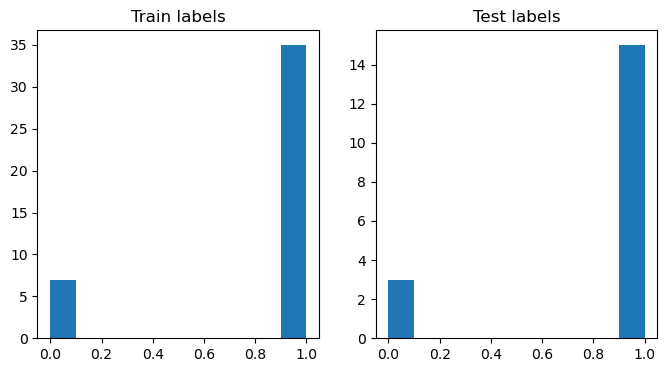

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

In [ ]:
n_dim = X_train.shape[1]
y_train = np.array(y_train)[:, np.newaxis]
y_test = np.array(y_test)[:, np.newaxis]
print(X_test.shape,
y_test.shape,
X_train.shape,
y_train.shape)

# Vowels

In [ ]:
vowelDataset, x ,y = vowelData ()
vowelDataset = vowelDataset.rename(columns={'feature12':'target'})
n_dim = x.shape[1]
target = 'target'
print("The dataset selected has shape: " + str(vowelDataset.shape) + " and for each class "+ str(Counter(vowelDataset[target])))

The dataset selected has shape: (990, 13) and for each class Counter({0: 90, 1: 90, 2: 90, 3: 90, 4: 90, 5: 90, 6: 90, 7: 90, 8: 90, 9: 90, 10: 90})


In [ ]:
out_class = [0,5,6,7,9]
in_class = 1
x_,y_ = split_inandout(out_class,in_class,target,vowelDataset,0.05)
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)

Counter({1: 90, 0: 20})
The number of records in the training dataset is 77
The number of records in the test dataset is 33
Counter({1: 63, 0: 14})


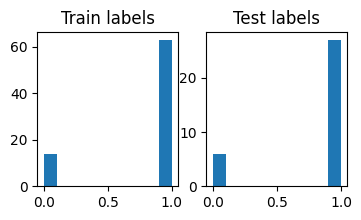

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(4,2))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

In [ ]:
y_train = np.array(y_train)[:, np.newaxis]
y_test = np.array(y_test)[:, np.newaxis]
print(X_test.shape,
y_test.shape,
X_train.shape,
y_train.shape)

(33, 12) (33, 1) (77, 12) (77, 1)


# BreastCancer

In [49]:
breast_dataset, x ,y = breastcancerData()
target = 'target'

print("The dataset selected has shape: " + str(breast_dataset.shape) + " and for each class "+ str(Counter(breast_dataset[target])))

The dataset selected has shape: (569, 31) and for each class Counter({1: 357, 0: 212})


In [50]:
out_class = [1]
in_class = 0
x_,y_ = split_inandout(out_class,in_class,target,breast_dataset,0.1)
# y_ = np.where(y_ == 1, 0, 1)
# Train test split
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)

Counter({1: 212, 0: 36})
The number of records in the training dataset is 173
The number of records in the test dataset is 75
Counter({1: 148, 0: 25})


In [ ]:
# Reduce dimensions (the dataset now has a dimensionality of 31 attributes)
n_dim = 12 #number of qubits we want to use
pca = PCA(n_components=n_dim).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
num_qubits = n_dim

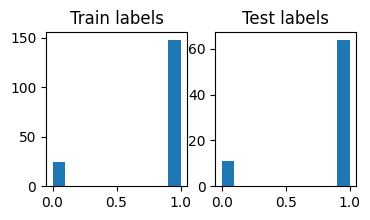

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(4,2))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

In [ ]:
n_dim = X_train.shape[1]
y_train = np.array(y_train)[:, np.newaxis]
y_test = np.array(y_test)[:, np.newaxis]
print(X_test.shape,
y_test.shape,
X_train.shape,
y_train.shape)

(75, 12) (75, 1) (173, 12) (173, 1)


# adhoc

In [15]:
adhoc_dataset, x ,y = breastcancerData()
target = 'target'
print("The dataset selected has shape: " + str(adhoc_dataset.shape) + " and for each class "+ str(Counter(adhoc_dataset[target])))

The dataset selected has shape: (569, 31) and for each class Counter({1: 357, 0: 212})


In [16]:
out_class = [0]
in_class = 1
x_,y_ = split_inandout(out_class,in_class,target,adhoc_dataset,0.1)
# Train test split
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)

Counter({1: 357, 0: 21})
The number of records in the training dataset is 264
The number of records in the test dataset is 114
Counter({1: 249, 0: 15})


In [17]:
# Reduce dimensions (the dataset now has a dimensionality of 31 attributes)
#number of qubits we want to use
pca = PCA(n_components=2).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
n_dim = X_train.shape[1]
num_qubits = n_dim

In [18]:
X_train.shape[1]

2

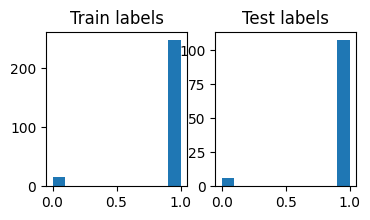

In [19]:
fig, ax = plt.subplots(1,2, figsize=(4,2))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

In [20]:
n_dim = X_train.shape[1]
y_train = np.array(y_train)[:, np.newaxis]
y_test = np.array(y_test)[:, np.newaxis]
print(X_test.shape,
y_test.shape,
X_train.shape,
y_train.shape)

(114, 2) (114, 1) (264, 2) (264, 1)


# Train the model for the chosen Dataset

In [57]:
# Define the number of layers to try

In [12]:
num_layers_list = [1,2,3,5,8,13,15]

In [ ]:
maxiterations = 20

In [ ]:
# Define the optimizers to try
optimizers = [
              # COBYLA(maxiter=maxiterations),
              SPSA(maxiter=maxiterations)
              # SLSQP(maxiter=maxiterations)
              ]

# Iterate over all combinations of feature maps, ansatzes and optimizers
for num_layers in num_layers_list:

    ansatzes = [
              RealAmplitudes(num_qubits=n_dim, reps=num_layers),
              # EfficientSU2(num_qubits=n_dim)
              ]
    feature_maps = [
              # ZZFeatureMap(feature_dimension=n_dim, reps=2),
              ZFeatureMap(feature_dimension=n_dim),
              # PauliFeatureMap(feature_dimension=n_dim)
              ]

    for i, (feature_map, ansatz, optimizer) in enumerate(product(feature_maps, ansatzes, optimizers)):
        print(f"Using {num_layers} layers")
        print(f"Using feature map: {feature_map.__class__.__name__}")
        print(f"Using ansatz: {ansatz.__class__.__name__}")
        print(f"Using optimizer: {optimizer.__class__.__name__}")

        train_vqc(X_train, y_train, X_test, y_test, num_layers, ansatz, feature_map, optimizer)
